## Imports
https://github.com/connorcoley/rexgen_direct/blob/master/notebooks/Data%20set%20analysis.ipynb <br>
https://github.com/Hanjun-Dai/GLN/tree/master/gln/data_process <br>
https://github.com/tentrillion/rdkit-tutorials/blob/master/notebooks <br>

In [154]:
import sys
import os
# sys.path.append('/usr/local/lib/python3.7/site-packages/') 
# for Colab 

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
import numpy as np

import matplotlib.pyplot as plt
params = {'text.usetex': True, 
          'text.latex.unicode': True,
          'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 6
plt.rcParams["text.latex.preamble"] = [
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath'
]

from itertools import chain, compress
import random
from tqdm import tqdm
import csv
import re 
import pickle

# from rdkit.Chem import PandasTools
# import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', 500)

## Load USPTO_STEREO
https://ibm.ent.box.com/v/ReactionSeq2SeqDataset <br> 
use this to clean https://github.com/Hanjun-Dai/GLN/blob/master/gln/data_process/clean_uspto.py <br>
### first, print first few rows of csv

In [83]:
with open(os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format('test'), 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    header = next(reader)
    print(header)
    print(next(reader))
    print(next(reader))
    print(next(reader))

['# Original data downloaded from: https://figshare.com/articles/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873, Sept 2017']
['# Author of original data: Daniel Lowe, License: CC0, DOI: 10.6084/m9.figshare.5104873.v1']
['Source', 'Target', 'CanonicalizedReaction', 'OriginalReaction', 'PatentNumber', 'ParagraphNum', 'Year', 'TextMinedYield', 'CalculatedYield']
['C S ( = O ) ( = O ) Cl . O C C C Br > A_CCN(CC)CC A_CCOCC', 'C S ( = O ) ( = O ) O C C C Br', 'CS(=O)(=O)Cl.OCCCBr>CCN(CC)CC.CCOCC>CS(=O)(=O)OCCCBr', '[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7](Cl)(=[O:9])=[O:8].CCOCC>C(N(CC)CC)C>[CH3:6][S:7]([O:5][CH2:4][CH2:3][CH2:2][Br:1])(=[O:9])=[O:8]', 'US03930836', '', '1976', '', '']


### Clean the USPTO_STEREO data

In [135]:
def get_rxn_smiles(mol_prod, reactants, original_reagents, remove_mapping=True):
    '''
    Adapted func from Hanjun Dai's GLN to additionally keep track of reagents (reactants that don't appear in products)
    Gets rid of reactants when they don't contribute to the product
    original_reagents: list of reagents in OriginalReaction, each element of list = 1 reagent
    remove_mapping: whether to remove atom mapping if atom in rct is not in prod
    '''
    prod_smi = Chem.MolToSmiles(mol_prod, True)
    prod_maps = set(re.findall('\:([[0-9]+)\]', prod_smi))
    reactants_smi_list = []
    
    reagent_smi_list = []
    if original_reagents:
        reagent_smi_list.append(original_reagents)
    
    for mol in reactants:
        if mol is None:
            continue
            
        used = False
        for a in mol.GetAtoms():
            if a.HasProp('molAtomMapNumber'):
                if a.GetProp('molAtomMapNumber') in prod_maps:
                    used = True 
                    
                elif remove_mapping: # removes atom mapping if atom in reactant is not in product
                    a.ClearProp('molAtomMapNumber')
                    
        if used:
            reactants_smi_list.append(Chem.MolToSmiles(mol, True))
        else:
            reagent_smi_list.append(Chem.MolToSmiles(mol, True))
            
    reactants_smi = '.'.join(reactants_smi_list)
    
    if reagent_smi_list:
        reagents_smi = '.'.join(reagent_smi_list)
    else:
        reagents_smi = ''
        
    return '{}>{}>{}'.format(reactants_smi, reagents_smi, prod_smi)

In [143]:
def clean_data(rxn_list, rxn_set, key, 
               remove_mapping = True, 
               filename = os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format(key)):
    '''
    rxn_list: list to put cleaned rxn
    rxn_set: set to put cleaned rxn
    key: to be looped between 'train', 'valid', 'test'
    remove_mapping: whether to remove atom mapping if atom in rct is not in prod
    filename: directory of data csv 
    '''
    print('Processing {}'.format(key))
    
    pt = re.compile(r':(\d+)]')
    clean_list = [] # to store cleaned rxn smiles
    set_rxn = set() # to store unique rxn smiles
    bad_mapping = 0
    bad_prod = 0
    missing_map = 0
    raw_num = 0
    bad_rxn = 0
    
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        next(reader) # pass first three rows of csv file
        next(reader)
        next(reader)
        
        for row in reader:
            rxn_smiles = row[3]
            all_reactants, reagents, prod = rxn_smiles.split('>')
            all_reactants = all_reactants.split()[0] # remove ' |f:1...'
            prod = prod.split()[0] # remove ' |f:1...'

            rids = ','.join(sorted(re.findall(pt, all_reactants)))
            pids = ','.join(sorted(re.findall(pt, prod)))
            if rids != pids:  # mapping is not 1:1
                bad_mapping += 1
                continue

            reactants = [Chem.MolFromSmiles(smi) for smi in all_reactants.split('.')]

            mol_prod = Chem.MolFromSmiles(prod)
            if mol_prod is None:  # rdkit is not able to parse the product
                bad_prod += 1
                continue
                
            # Make sure all have atom mapping
            if not all([a.HasProp('molAtomMapNumber') for a in mol_prod.GetAtoms()]):
                missing_map += 1
                continue

            raw_num += 1
            rxn_smiles = get_rxn_smiles(mol_prod, reactants, reagents, remove_mapping)
            # '{}>{}>{}'.format(reactants, reagents, product) 
            # if remove_mapping: rct atom mapping removed if atom doesn't appear in prod

#             if not rxn_smiles in set_rxn: 
            # removes dup rxns: do not want to do this for data analysis
            clean_list.append(rxn_smiles) #ignore PatentNumber
            set_rxn.add(rxn_smiles)

            if raw_num%40000 == 0:
                print('Extracted: {} raw rxn'.format(raw_num))

        rxn_list[key] = clean_list
        rxn_set[key] = set_rxn
        
        print('# clean rxn:', len(clean_list))
        print('# unique rxn:', len(set_rxn))
        print('bad mapping:', bad_mapping)
        print('bad prod:', bad_prod)
        print('missing map:', missing_map)
        print('raw rxn extracted:', raw_num, '\n')

In [139]:
clean_rxn_nomap = {'train': None, 'valid': None, 'test': None}
clean_rxn_nomap_set = {'train': None, 'valid': None, 'test': None}

for key in clean_rxn_nomap.keys():
    clean_data(clean_rxn_nomap, clean_rxn_nomap_set, key, True, 
              os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format(key))

Processing train
Extracted: 40000 raw rxn
Extracted: 80000 raw rxn
Extracted: 120000 raw rxn
Extracted: 160000 raw rxn
Extracted: 200000 raw rxn
Extracted: 240000 raw rxn
Extracted: 280000 raw rxn
Extracted: 320000 raw rxn
Extracted: 360000 raw rxn
Extracted: 400000 raw rxn
Extracted: 440000 raw rxn
Extracted: 480000 raw rxn
Extracted: 520000 raw rxn
Extracted: 560000 raw rxn
Extracted: 600000 raw rxn
Extracted: 640000 raw rxn
Extracted: 680000 raw rxn
Extracted: 720000 raw rxn
Extracted: 760000 raw rxn
Extracted: 800000 raw rxn
Extracted: 840000 raw rxn
# clean rxn: 865901
# unique rxn: 865898
bad mapping: 36680
bad prod: 0
missing map: 0
raw rxn extracted: 865901 

Processing valid
Extracted: 40000 raw rxn
# clean rxn: 48119
# unique rxn: 48118
bad mapping: 2012
bad prod: 0
missing map: 0
raw rxn extracted: 48119 

Processing test
Extracted: 40000 raw rxn
# clean rxn: 48165
# unique rxn: 48165
bad mapping: 2093
bad prod: 0
missing map: 0
raw rxn extracted: 48165 



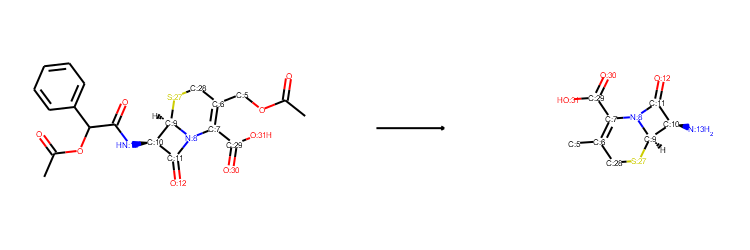

In [172]:
curr_rxn = 'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[O:30])[OH:31])[N:8]2[C@@H:9]([C@H:10]([NH2:13])[C:11]2=[O:12])[S:27][CH2:28]1'
Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(curr_rxn, useSmiles=True), (250, 250))

### Save as pickle to avoid running this very long cleaning step again

In [140]:
with open('clean_rxn.pickle', 'wb') as handle:
    pickle.dump(clean_rxn_nomap, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clean_rxn_set.pickle', 'wb') as handle:
    pickle.dump(clean_rxn_nomap_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

### do not remove atom mappings for rct atoms not in prod

In [ ]:
clean_rxn_allmap = {'train': None, 'valid': None, 'test': None}
clean_rxn_allmap_set = {'train': None, 'valid': None, 'test': None}

for key in clean_rxn_nodrop.keys():
    clean_data(clean_rxn_nodrop, clean_rxn_nodrop_set, key, False, 
              os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format(key))

with open('clean_rxn_nodrop.pickle', 'wb') as handle:
pickle.dump(clean_rxn_nodrop, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clean_rxn_nodrop_set.pickle', 'wb') as handle:
    pickle.dump(clean_rxn_nodrop_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Eyeball some rxns. 
- hydrolysis of penicillin

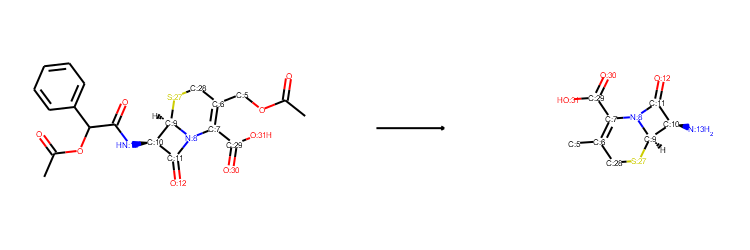

In [46]:
curr_rxn = 'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[O:30])[OH:31])[N:8]2[C@@H:9]([C@H:10]([NH2:13])[C:11]2=[O:12])[S:27][CH2:28]1'

Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(curr_rxn, useSmiles=True), (250, 250))

### Count # of reactant fragments that end up in the product

In [144]:
from collections import Counter

num_rcts = {}
for key in clean_rxn_nomap.keys():
    num_rcts_list = [smarts.split('>')[0].count('.')+1 for smarts in clean_rxn_nomap[key]]
    num_rcts[key] = Counter(num_rcts_list)
    
    print('# reactant fragments in {}: '.format(key))
    print(num_rcts[key], '\n')

# reactant fragments in train: 
Counter({2: 599958, 1: 201929, 3: 51141, 4: 10324, 5: 2152, 6: 324, 7: 56, 8: 13, 9: 4}) 

# reactant fragments in valid: 
Counter({2: 33202, 1: 11323, 3: 2839, 4: 604, 5: 116, 6: 30, 7: 5}) 

# reactant fragments in test: 
Counter({2: 33278, 1: 11368, 3: 2826, 4: 572, 5: 107, 6: 11, 7: 2, 8: 1}) 



In [145]:
num_prods = {}
for key in clean_rxn_nomap.keys():
    num_prods_list = [smarts.split('>')[-1].count('.')+1 for smarts in clean_rxn_nomap[key]]
    num_prods[key] = Counter(num_prods_list)
    
    print('# products in {}: '.format(key))
    print(num_prods[key], '\n')

# products in train: 
Counter({1: 865901}) 

# products in valid: 
Counter({1: 48119}) 

# products in test: 
Counter({1: 48165}) 



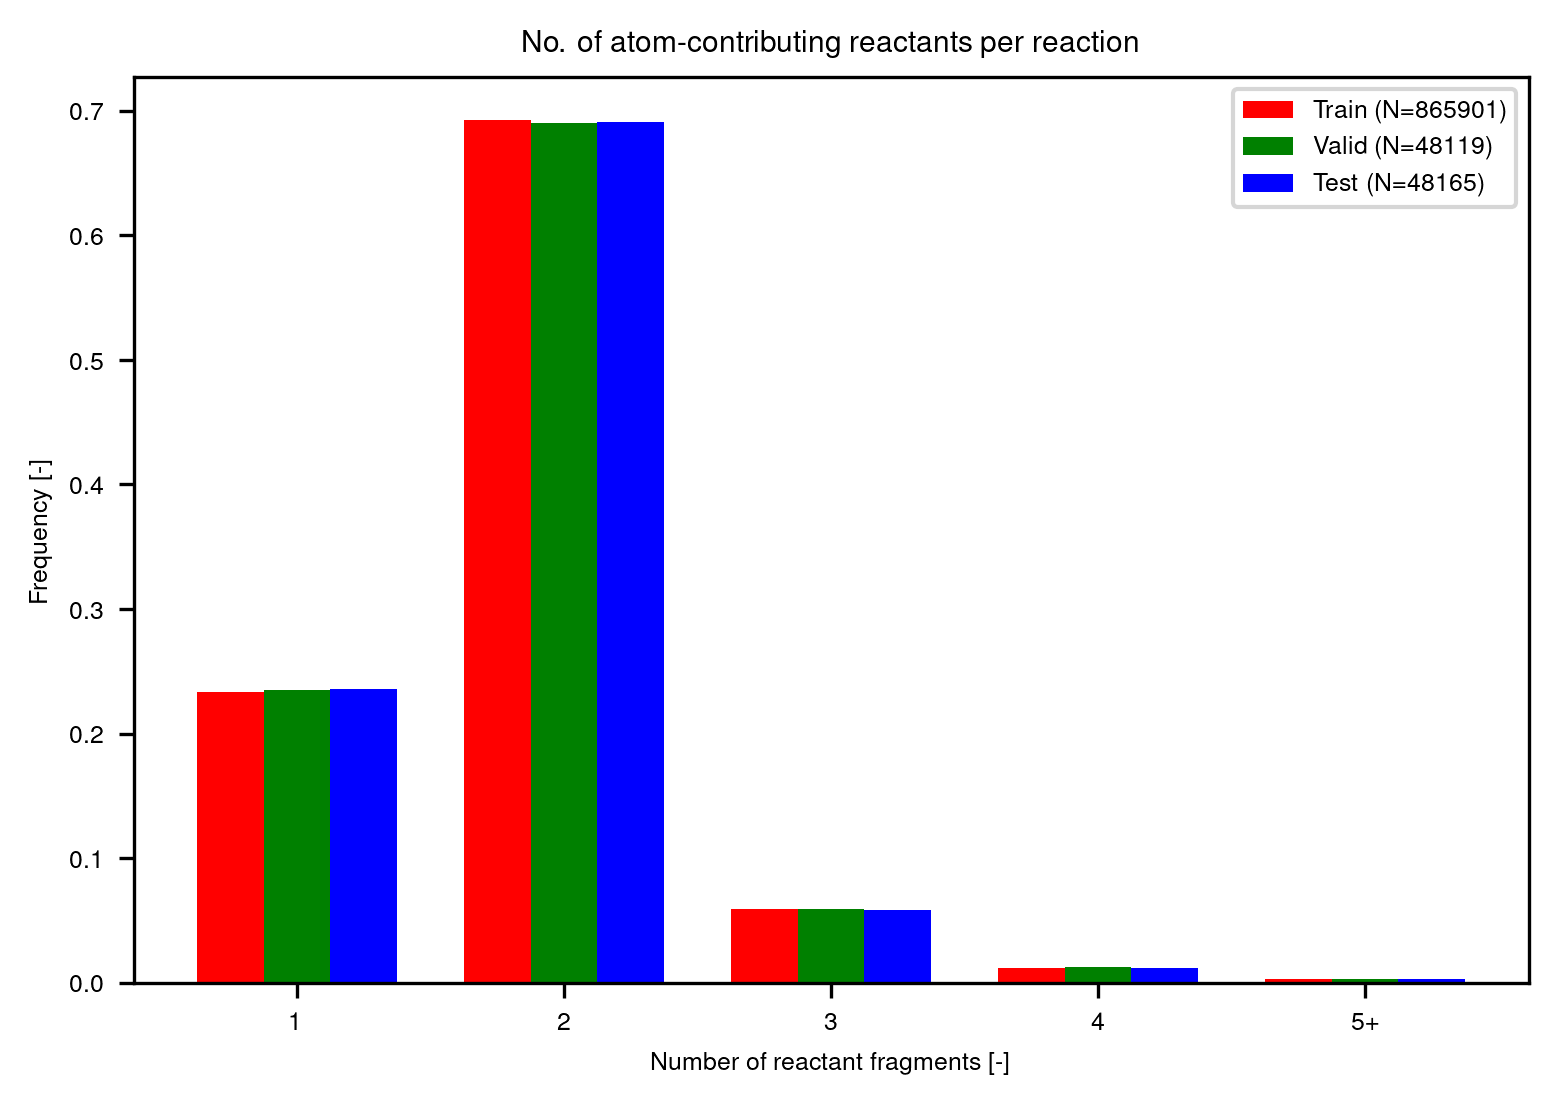

In [147]:
n = 6
dataset = 'USPTO_STEREO'
fig = plt.figure(figsize=(6,4), dpi = 300)
colors = ['r', 'g', 'b']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    counter = num_rcts[key]
    counts_sum = sum(counter.values())
    xs = np.arange(1, n)
    xs[-1] = 1e9
    counts = np.zeros(np.shape(xs))
    
    for (k, v) in sorted(counter.items(), key=lambda x: x[0], reverse=True):
        for i in range(len(counts)):
            if xs[i] >= k:
                counts[i] = counts[i] + v
                break
                
    plt.bar(np.arange(len(counts)) + (offset-1)*.25, 
            counts / counts_sum, width=0.25,
            color=colors[offset])
    
plt.xlabel('Number of reactant fragments [-]')
xticklabels = [str(k) for k in xs if k != 1e9]
xticklabels.append('{}+'.format(xs[-2]+1))
plt.xticks(range(len(counts)), xticklabels)
plt.ylabel('Frequency [-]')
plt.legend(['Train (N={})'.format(len(clean_rxn_nomap['train'])), 
            'Valid (N={})'.format(len(clean_rxn_nomap['valid'])), 
            'Test (N={})'.format(len(clean_rxn_nomap['test']))])

plt.title('No. of atom-contributing reactants per reaction') # Raised Error when I used '# of reactants' instd of #No. of
plt.savefig(os.getcwd()+'/analysis/{}_num_reactant_frags.png'.format(dataset), bbox_inches = 'tight')
plt.show()

### Let's not bother with this for now. Print all elements in reactants. Takes a while 
https://regexr.com/ <br>

### TO DO: 
- regex needs all atoms in rcts to be atom-mapped. this is NOT the case as atoms not in prod are not numbered in this database.
- SO, I can: change the regex to recognise atoms without number mappings OR 
- find a way to number all atoms in rcts

In [ ]:
# DOESN'T WORK AS INTENDED FOR NOW!!! STEREO tokens not compatible with current regex
from collections import defaultdict

atom_id_rcts = {}
for key in clean_rxn_nodrop.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn_nodrop[key]:
        rcts = smarts.split('>')[0]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_rcts[key] = occurrences
    
atom_id_prods = {}
for key in clean_rxn_nodrop.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn_nodrop[key]:
        rcts = smarts.split('>')[-1]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_prods[key] = occurrences
    
all_atom_types = set()
for key in clean_rxn_nodrop.keys():
    all_atom_types |= set(atom_id_rcts[key].keys()) # all atoms in rcts will appear in prods
all_atom_types = sorted(all_atom_types, key=lambda x: atom_id_rcts['train'][x], reverse=True)

print(all_atom_types)

Freq Carbon in train: 69.26%
Freq Carbon in valid: 69.30%
Freq Carbon in test: 69.22%


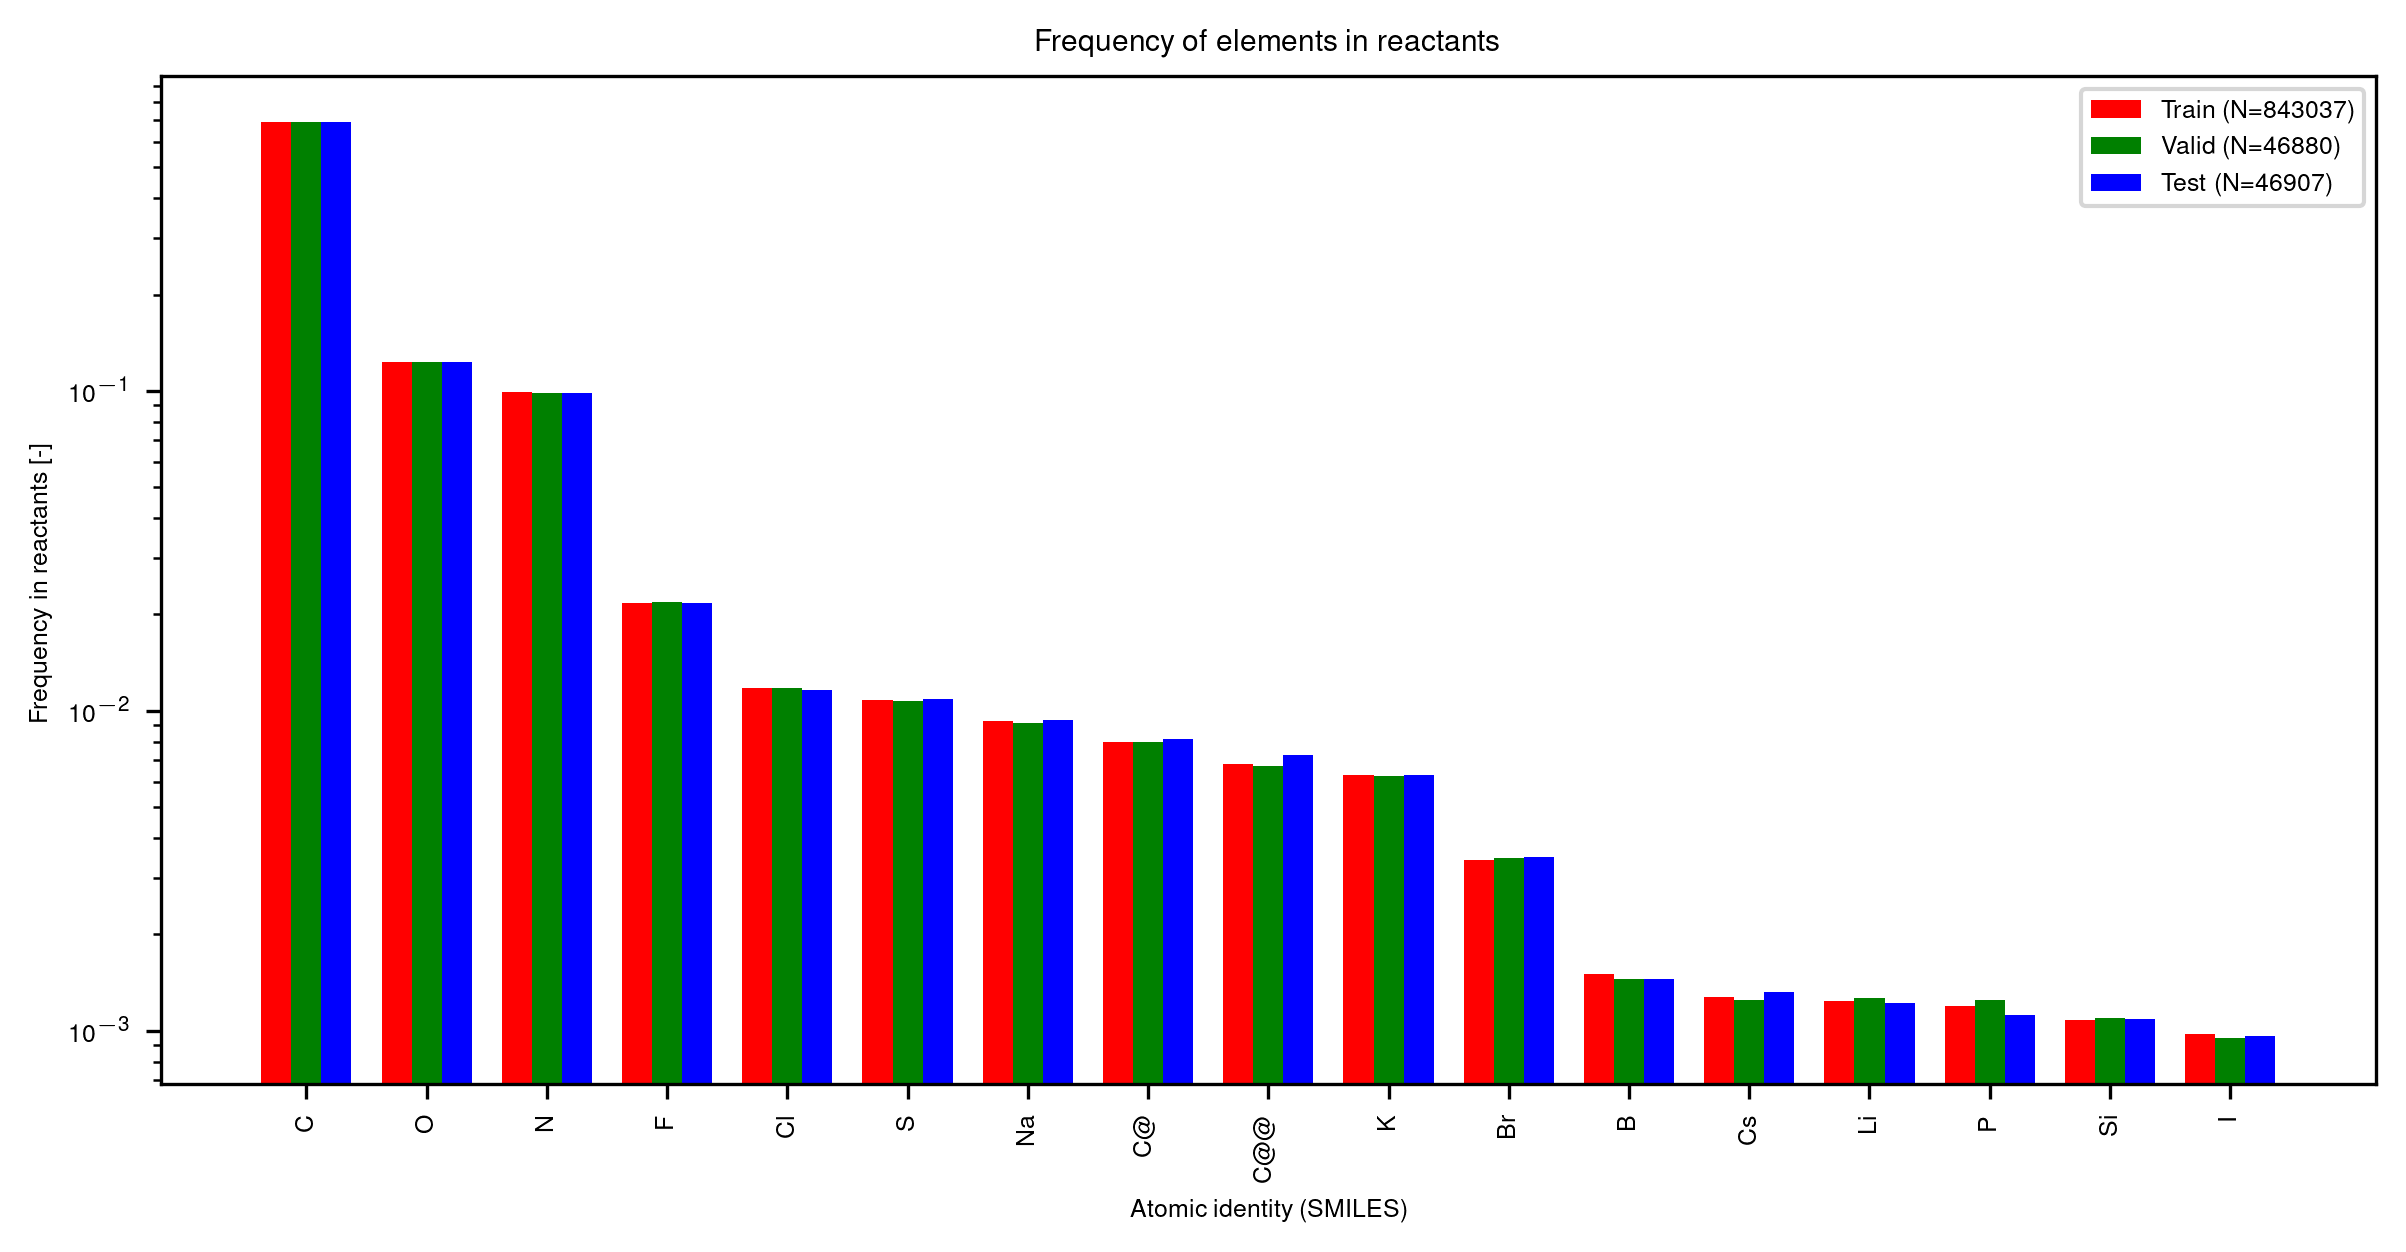

In [96]:
# fig = plt.figure(figsize=(8,4), dpi = 300)
# colors = ['r', 'g', 'b']

# for offset, key in enumerate(['train', 'valid', 'test']):
    
#     vals = []
#     for atom_type in all_atom_types[:17]:
#         vals.append(atom_id_rcts[key][atom_type])
#     vals = np.array(vals)
        
#     plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
#             vals / np.sum(vals), width=0.25,
#             color=colors[offset])
#     print('Freq Carbon in {}: {:.2f}%'.format(key, 100*vals[0]/np.sum(vals)))
    
# plt.xlabel('Atomic identity (SMILES)')
# plt.xticks(range(len(vals)), 
#            ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
#           rotation='vertical')
# plt.ylabel('Frequency in reactants [-]')
# # plt.grid(True)
# plt.legend(['Train (N={})'.format(len(clean_rxn['train'])), 
#             'Valid (N={})'.format(len(clean_rxn['valid'])), 
#             'Test (N={})'.format(len(clean_rxn['test']))])
# plt.yscale('log')
# plt.tight_layout()
# plt.title('Frequency of elements in reactants')
# # plt.savefig(os.getcwd()+'/analysis/{}_atom_type_freqs.png'.format(dataset), bbox_inches = 'tight')
# plt.show()

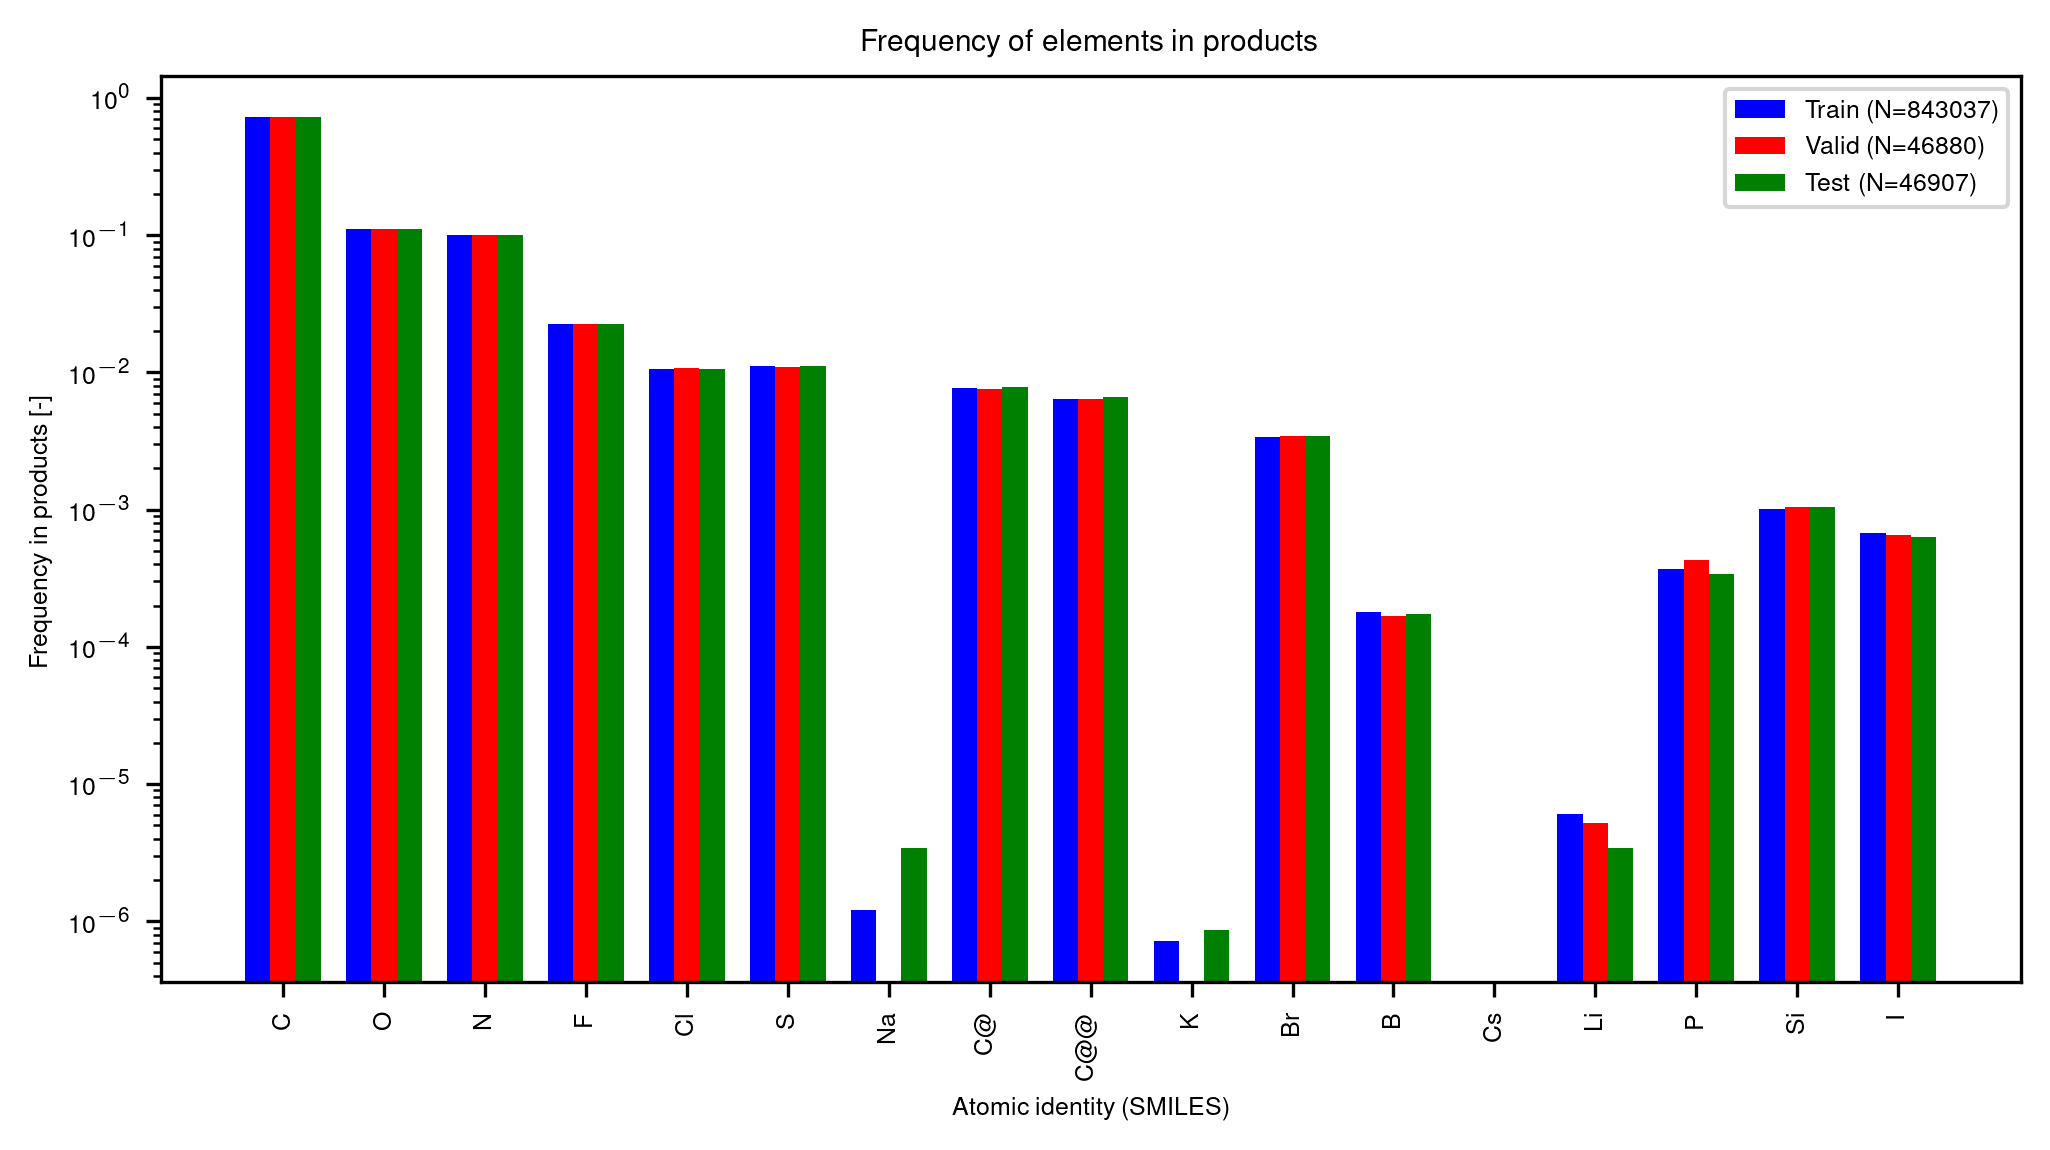

In [98]:
# fig = plt.figure(figsize=(8,4), dpi = 300)
# colors = ['b', 'r', 'g']

# for offset, key in enumerate(['train', 'valid', 'test']):
    
#     vals = []
#     for atom_type in all_atom_types[:17]:
#         vals.append(atom_id_prods[key][atom_type])
#     vals = np.array(vals)
        
#     plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
#             vals / np.sum(vals), width=0.25,
#             color=colors[offset])
    
# plt.xlabel('Atomic identity (SMILES)')
# plt.xticks(range(len(vals)), 
#            ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
#           rotation='vertical')
# plt.ylabel('Frequency in products [-]')
# # plt.grid(True)
# plt.legend(['Train (N={})'.format(len(clean_rxn['train'])), 
#             'Valid (N={})'.format(len(clean_rxn['valid'])), 
#             'Test (N={})'.format(len(clean_rxn['test']))])
# plt.yscale('log')
# plt.title('Frequency of elements in products')
# # plt.savefig(os.getcwd()+'/analysis/{}_atom_type_freqs_prods.png'.format(dataset), bbox_inches = 'tight')
# plt.show()

### Calculate unique # products, unique # reactants, unique # reagents

In [148]:
products = {}
for key in clean_rxn_nomap.keys():
    products[key] = [smarts.split('>')[-1] for smarts in clean_rxn_nomap[key]]

unique_products = {}
for key in clean_rxn_nomap.keys():
    unique_products[key] = set(products[key])
    
    print('# reactions in {}: {}'.format(key, len(products[key])))
    print('# unique pdts in {}: {} \n'.format(key, len(unique_products[key])))

# reactions in train: 865901
# unique pdts in train: 843743 

# reactions in valid: 48119
# unique pdts in valid: 47047 

# reactions in test: 48165
# unique pdts in test: 47028 



In [149]:
reactants = {}
for key in clean_rxn_nomap.keys():
    reactants[key] = [smarts.split('>')[0].split('.') for smarts in clean_rxn_nomap[key]]
    
unique_reactants = {}
for key in clean_rxn_nomap.keys():
    unique_reactants[key] = set(chain.from_iterable(reactants[key]))
    
    print('# reactions in {}: {}'.format(key, len(reactants[key])))
    print('# total reactants in {}: {}'.format(key, len(list(chain.from_iterable(reactants[key])))))
    print('# unique reactants in {}: {} \n'.format(key, len(unique_reactants[key])))

# reactions in train: 865901
# total reactants in train: 1609800
# unique reactants in train: 949362 

# reactions in valid: 48119
# total reactants in valid: 89455
# unique reactants in valid: 75002 

# reactions in test: 48165
# total reactants in test: 89313
# unique reactants in test: 74480 



In [195]:
reagents = {}
for key in clean_rxn_nomap.keys():
    reagents[key] = [smarts.split('>')[1].split('.') for smarts in clean_rxn_nomap[key]]
    
unique_reagents = {}
for key in clean_rxn_nomap.keys():
    unique_reagents[key] = set(chain.from_iterable(reagents[key]))
    
    print('# reactions in {}: {}'.format(key, len(reagents[key])))
    print('# total reagents in {}: {}'.format(key, len(list(chain.from_iterable(reagents[key])))))
    print('# unique reagents in {}: {} \n'.format(key, len(unique_reagents[key])))

# reactions in train: 865901
# total reagents in train: 2878011
# unique reagents in train: 32217 

# reactions in valid: 48119
# total reagents in valid: 158946
# unique reagents in valid: 4166 

# reactions in test: 48165
# total reagents in test: 159937
# unique reagents in test: 4274 



### possible Suzuki couplings (to do: find better way of finding specific rxn: prolly by using SMARTS tokens or using the bond edits data)

In [215]:
B_rxn = {}
for key in clean_rxn_nomap.keys():
    # check for B not followed by r
    B_mask = [re.search("B(?!r)", rxn_smi) for rxn_smi in clean_rxn_nomap[key]]
    B_rxn[key] = list(compress(clean_rxn_nomap[key], B_mask))
    
    # check for B not followed by H
    B_mask = [re.search("B(?!H)", rxn_smi) for rxn_smi in B_rxn[key]]
    B_rxn[key] = list(compress(B_rxn[key], B_mask))
    
    suzuki_count = sum( (('Pd' in rxn_smi) or ('Ni' in rxn_smi) or ('Fe' in rxn_smi) or 
                        ('Cu' in rxn_smi) or ('Ru' in rxn_smi))  
                       for rxn_smi in B_rxn[key] )
    
    print('likely Suzuki coupling in {}: {:.3f}%'.format(key,
                                                         100 * suzuki_count / len(clean_rxn_nomap[key])))
    print('# rxn in {}: {} \n'.format(key, suzuki_count))

likely Suzuki coupling in train: 2.555%
# rxn in train: 22128 

likely Suzuki coupling in valid: 2.502%
# rxn in valid: 1204 

likely Suzuki coupling in test: 2.682%
# rxn in test: 1292 



### Randomly selects a rxn fitting specified criteria
- STRANGE! Atom mapping is wrong...carbon in product doesn't come from $PPh_{3}$...should be from the 2-propylene bromide

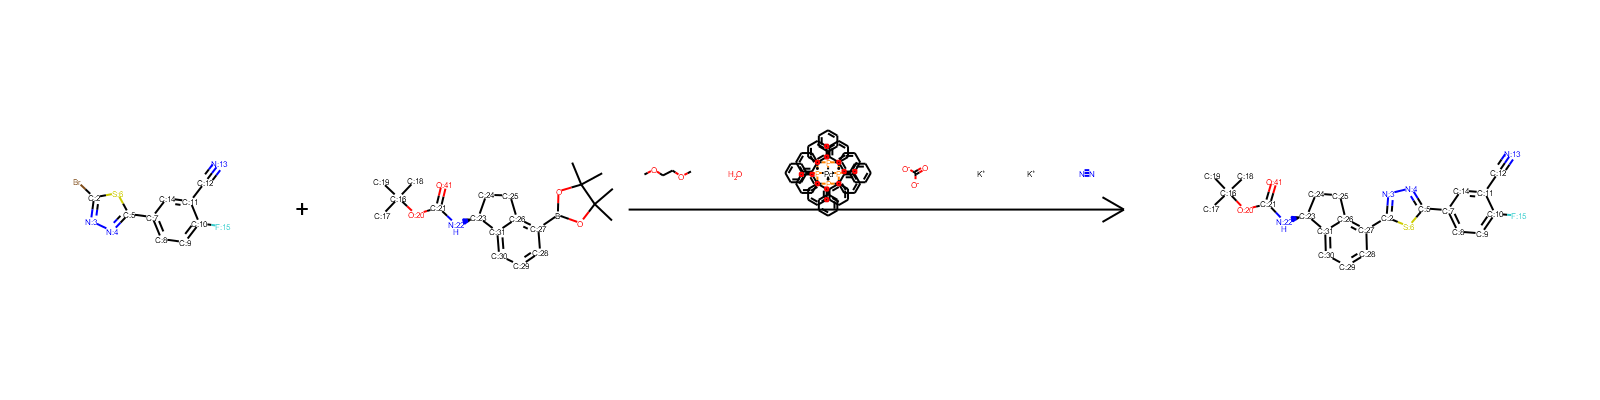

In [216]:
key = 'train'
suzuki_catalyst_mask = [(('Pd' in rxn_smi) or ('Ni' in rxn_smi) or ('Fe' in rxn_smi) or 
                        ('Cu' in rxn_smi) or ('Ru' in rxn_smi))
                        for rxn_smi in B_rxn[key]]
current_rxn = rdChemReactions.ReactionFromSmarts(random.choice(list(compress(B_rxn[key], suzuki_catalyst_mask))), 
                                                 useSmiles=True)

Draw.ReactionToImage(current_rxn, (400, 400))

### Transition metals

In [194]:
TM_list = ['Pd', 'Cu', 'Fe', 'Cr', 'Mn', 'Ti', 'Pt', 'Ni', 'Ru', 'Rh', 'Os', 'Co', 'W', 'Zr', 'Mo', 'Ir',
          'Sc', 'Re', 'Au', 'Ta', 'V', 'Y', 'La']

for key in clean_rxn_nomap.keys():
    TM_count = 0
    for rxn_smi in clean_rxn_nodrop[key]:
        for TM in TM_list:
            if TM in rxn_smi:
                TM_count += 1
                break  # avoid double counting if transition metal appears twice or more in rxn_smi
    
    print('Rxn involving transition metals in {}: {:.3f}%'.format(key, 
                                                         100 * TM_count / len(clean_rxn_nomap[key])))
    print('# rxn in {}: {} \n'.format(key, TM_count))

Rxn involving transition metals in train: 11.558%
# rxn in train: 100082 

Rxn involving transition metals in valid: 11.667%
# rxn in valid: 5614 

Rxn involving transition metals in test: 11.853%
# rxn in test: 5709 



### Halogens

In [188]:
halo_list = ['F', 'Cl', 'Br', 'I']

for key in clean_rxn_nodrop.keys():
    halo_count = 0
    halo_count_rctonly = 0
    for rxn_smi in clean_rxn_nodrop[key]:
        for halo in halo_list:
            if halo in rxn_smi:
                halo_count += 1
                break  # avoid double counting if halogen appears twice or more in rxn_smi
                
        for halo in halo_list:
            if halo in rxn_smi.split('>')[0]:
                halo_count_rctonly += 1
                break  # avoid double counting if halogen appears twice or more in reactants
    
    print('Rxn w/ >=1 halogen (reactant or reagent) in {}: {:.3f}%'.format(key, 
                                                         100 * halo_count / len(clean_rxn_nodrop[key])))
    print('# rxn in {}: {}'.format(key, halo_count))
    
    print('Rxn w/ >=1 halogen (reactant only) in {}: {:.3f}%'.format(key, 
                                                         100 * halo_count_rctonly / len(clean_rxn_nodrop[key])))
    print('# rxn in {}: {} \n'.format(key, halo_count_rctonly))

Rxn w/ >=1 halogen (reactant or reagent) in train: 80.508%
# rxn in train: 697117
Rxn w/ >=1 halogen (reactant only) in train: 77.318%
# rxn in train: 669499 

Rxn w/ >=1 halogen (reactant or reagent) in valid: 80.648%
# rxn in valid: 38807
Rxn w/ >=1 halogen (reactant only) in valid: 77.549%
# rxn in valid: 37316 

Rxn w/ >=1 halogen (reactant or reagent) in test: 80.206%
# rxn in test: 38631
Rxn w/ >=1 halogen (reactant only) in test: 77.108%
# rxn in test: 37139 



In [ ]:
# this is wrong, double counts (or even more) rxn that contain >1 halogen
halo_list = ['F', 'Cl', 'Br', 'I']

for key in clean_rxn_nodrop.keys():
    halo_count = 0
    for halo in halo_list:
        halo_count += sum(halo in rxn_smi for rxn_smi in clean_rxn_nodrop[key])
    
    print('Rxn w/ >=1 halogen in {}: {:.3f}%'.format(key, 
                                                         100 * halo_count / len(clean_rxn_nodrop[key])))
    print('# rxn in {}: {} \n'.format(key, halo_count))

### Noble elements

In [191]:
noble_list = ['He', 'Ar', 'Ne', 'Xe', 'Kr', 'Og', 'Rn']

for key in clean_rxn_nomap.keys():
    noble_count = 0
    for rxn_smi in clean_rxn_nodrop[key]:
        for noble in noble_list:
            if noble in rxn_smi:
                noble_count += 1
                break  # avoid double counting if noble element appears twice or more in rxn_smi
    
    print('Rxn involving noble gas elements in {}: {:.3f}%'.format(key, 
                                                         100 * noble_count / len(clean_rxn_nomap[key])))
    print('# rxn in {}: {} \n'.format(key, noble_count))

Rxn involving noble gas elements in train: 0.002%
# rxn in train: 20 

Rxn involving noble gas elements in valid: 0.002%
# rxn in valid: 1 

Rxn involving noble gas elements in test: 0.004%
# rxn in test: 2 



### Lanthanides

In [192]:
lanth_list = ['Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']

for key in clean_rxn_nomap.keys():
    lanth_count = 0
    for rxn_smi in clean_rxn_nodrop[key]:
        for lanth in lanth_list:
            if lanth in rxn_smi:
                lanth_count += 1
                break  # avoid double counting if noble element appears twice or more in rxn_smi
    
    print('Rxn involving lanthanides in {}: {:.3f}%'.format(key, 
                                                         100 * lanth_count / len(clean_rxn_nomap[key])))
    print('# rxn in {}: {} \n'.format(key, lanth_count))

Rxn involving lanthanides in train: 0.081%
# rxn in train: 699 

Rxn involving lanthanides in valid: 0.087%
# rxn in valid: 42 

Rxn involving lanthanides in test: 0.098%
# rxn in test: 47 



### How to identify ligands? 
- NHC ligands, Phosphines (saw a bunch)
- ideas: substructure search for NHC
- for phosphine, search for P bonded to 3 other atoms? yes, that is possible
- or search P + TM 

### How to identify solvents etc.
- substructure search for hardcoded list of solvents?
- or is there a more clever way of identifying solvents